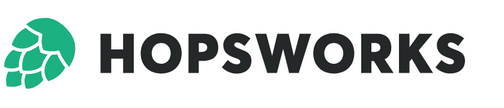

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/quickstart.ipynb)

**Note**: you may get an error when installing hopsworks on Colab, and it is safe to ignore it.

In [1]:
!pip install -U hopsworks --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 759.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.9 MB/s eta 0:00:00
  Preparing metad

## <span style="color:#ff5f27;"> 💽 Loading the Data </span>

The data you will use comes from three different CSV files:

* credit_cards.csv: information such as the expiration date and provider.
* transactions.csv: events containing information about when a credit card was used, such as a timestamp, location, and the amount spent. A boolean fraud_label variable (True/False) tells us whether a transaction was fraudulent or not.
* profiles.csv: credit card user information such as birthdate and city of residence.

In a production system, these CSV files would originate from separate data sources or tables, and probably separate data pipelines. All three files have a common credit card number column cc_num, which you will use later to join features together from the different datasets.

Now, you can go ahead and load the data.


In [2]:
import joblib
import os
import time

import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns
from math import radians

import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Mute warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Specify the window length as "4h"
window_len = "4h"

# Specify the URL for the data
url = "https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_data/"

In [4]:
# Read the 'credit_cards.csv' file
credit_cards_df = pd.read_csv(url + "credit_cards.csv")

# Read the 'profiles.csv' file
# Parse the 'birthdate' column as dates
profiles_df = pd.read_csv(url + "profiles.csv", parse_dates=["birthdate"])

# Read the 'transactions.csv' file
# Parse the 'datetime' column as dates
trans_df = pd.read_csv(url + "transactions.csv", parse_dates=["datetime"])

# Display the first 3 rows of the 'transactions.csv' DataFrame
trans_df.head(3)

,tid,datetime,cc_num,category,amount,latitude,longitude,city,country,fraud_label
0,11df919988c134d97bbff2678eb68e22,2022-01-01 00:00:24,4473593503484549,Health/Beauty,62.95,42.30865,-83.48216,Canton,US,0
1,dd0b2d6d4266ccd3bf05bc2ea91cf180,2022-01-01 00:00:56,4272465718946864,Grocery,85.45,33.52253,-117.70755,Laguna Niguel,US,0
2,e627f5d9a9739833bd52d2da51761fc3,2022-01-01 00:02:32,4104216579248948,Domestic Transport,21.63,37.60876,-77.37331,Mechanicsville,US,0


## <span style="color:#ff5f27;"> 🛠️ Feature Engineering </span>

Fraudulent transactions can differ from regular ones in many different ways. Typical red flags would for instance be a large transaction volume/frequency in the span of a few hours. It could also be the case that elderly people in particular are targeted by fraudsters. To facilitate model learning, we will create additional features based on these patterns. In particular, we will create two types of features:

* Features that aggregate data from different data sources. This could for instance be the age of a customer at the time of a transaction, which combines the birthdate feature from profiles.csv with the datetime feature from transactions.csv.
* Features that aggregate data from multiple time steps. An example of this could be the transaction frequency of a credit card in the span of a few hours, which is computed using a window function.

Now you are ready to start with the first category.


In [5]:
# Merge the 'trans_df' DataFrame with the 'profiles_df' DataFrame based on the 'cc_num' column
age_df = trans_df.merge(profiles_df, on="cc_num", how="left")

# Compute the age at the time of each transaction and store it in the 'age_at_transaction' column
trans_df["age_at_transaction"] = (age_df["datetime"] - age_df["birthdate"]) / np.timedelta64(365, "D")

# Merge the 'trans_df' DataFrame with the 'credit_cards_df' DataFrame based on the 'cc_num' column
card_expiry_df = trans_df.merge(credit_cards_df, on="cc_num", how="left")

# Convert the 'expires' column to datetime format
card_expiry_df["expires"] = pd.to_datetime(card_expiry_df["expires"], format="%m/%y")

# Compute the days until the card expires and store it in the 'days_until_card_expires' column
trans_df["days_until_card_expires"] = (card_expiry_df["expires"] - card_expiry_df["datetime"]) / np.timedelta64(1, "D")

# Display the 'age_at_transaction' and 'days_until_card_expires' columns for the first few rows
trans_df[["age_at_transaction", "days_until_card_expires"]].head()

,age_at_transaction,days_until_card_expires
0,97.578083,1460.999722
1,33.775344,1733.999352
2,80.953429,242.998241
3,53.561650,150.997639
4,46.035624,515.997280


The next step is that you will create features from aggregations that are computed over every credit card over multiple time steps.

You start by computing a feature that captures the physical distance between consecutive transactions, which we will call `loc_delta`. Here, you will use Haversine distance to quantify the distance between two longitude and latitude coordinates.


In [6]:
# Sort the 'trans_df' DataFrame based on the 'datetime' column in ascending order
trans_df.sort_values("datetime", inplace=True)

# Convert the 'longitude' and 'latitude' columns to radians
trans_df[["longitude", "latitude"]] = trans_df[["longitude", "latitude"]].applymap(radians)

# Define a function to compute Haversine distance between consecutive coordinates
def haversine(long, lat):
    """Compute Haversine distance between each consecutive coordinate in (long, lat)."""

    # Shift the longitude and latitude columns to get consecutive values
    long_shifted = long.shift()
    lat_shifted = lat.shift()

    # Calculate the differences in longitude and latitude
    long_diff = long_shifted - long
    lat_diff = lat_shifted - lat

    # Haversine formula to compute distance
    a = np.sin(lat_diff/2.0)**2
    b = np.cos(lat) * np.cos(lat_shifted) * np.sin(long_diff/2.0)**2
    c = 2*np.arcsin(np.sqrt(a + b))

    return c

# Apply the haversine function to compute the 'loc_delta' column
trans_df["loc_delta"] = trans_df.groupby("cc_num")\
    .apply(lambda x : haversine(x["longitude"], x["latitude"]))\
    .reset_index(level=0, drop=True)\
    .fillna(0)

Next you will compute windowed aggregates. Here you will use 4-hour windows, but feel free to experiment with different window lengths by setting `window_len` below to a value of your choice.

In [7]:
# Define a rolling window groupby on 'cc_num' with a specified window length on the 'datetime' column
cc_group = trans_df[["cc_num", "amount", "datetime"]].groupby("cc_num").rolling(
    window_len,
    on="datetime",
)

# Moving average of transaction volume.
df_4h_mavg = pd.DataFrame(cc_group.mean())
df_4h_mavg.columns = ["trans_volume_mavg", "datetime"]
df_4h_mavg = df_4h_mavg.reset_index(level=["cc_num"])
df_4h_mavg = df_4h_mavg.drop(columns=["cc_num", "datetime"])
df_4h_mavg = df_4h_mavg.sort_index()

# Moving standard deviation of transaction volume.
df_4h_std = pd.DataFrame(cc_group.std())
df_4h_std.columns = ["trans_volume_mstd", "datetime"]
df_4h_std = df_4h_std.reset_index(level=["cc_num"])
df_4h_std = df_4h_std.drop(columns=["cc_num", "datetime"])
df_4h_std = df_4h_std.fillna(0)
df_4h_std = df_4h_std.sort_index()
window_aggs_df = df_4h_std.merge(df_4h_mavg, left_index=True, right_index=True)

# Moving transaction frequency.
df_4h_count = pd.DataFrame(cc_group.count())
df_4h_count.columns = ["trans_freq", "datetime"]
df_4h_count = df_4h_count.reset_index(level=["cc_num"])
df_4h_count = df_4h_count.drop(columns=["cc_num", "datetime"])
df_4h_count = df_4h_count.sort_index()
window_aggs_df = window_aggs_df.merge(df_4h_count, left_index=True, right_index=True)

# Moving average of location difference between consecutive transactions.
cc_group_loc_delta = trans_df[["cc_num", "loc_delta", "datetime"]].groupby("cc_num").rolling(window_len, on="datetime").mean()
df_4h_loc_delta_mavg = pd.DataFrame(cc_group_loc_delta)
df_4h_loc_delta_mavg.columns = ["loc_delta_mavg", "datetime"]
df_4h_loc_delta_mavg = df_4h_loc_delta_mavg.reset_index(level=["cc_num"])
df_4h_loc_delta_mavg = df_4h_loc_delta_mavg.drop(columns=["cc_num", "datetime"])
df_4h_loc_delta_mavg = df_4h_loc_delta_mavg.sort_index()
window_aggs_df = window_aggs_df.merge(df_4h_loc_delta_mavg, left_index=True, right_index=True)

# Merge 'trans_df' with selected columns for the final result
window_aggs_df = window_aggs_df.merge(
    trans_df[["cc_num", "datetime"]].sort_index(),
    left_index=True,
    right_index=True,
)
window_aggs_df.tail()

,trans_volume_mstd,trans_volume_mavg,trans_freq,loc_delta_mavg,cc_num,datetime
106015,0.0,73.08,1.0,0.045635,4032019521897961,2022-03-24 10:57:02
106016,0.0,287.33,1.0,0.045846,4032019521897961,2022-03-28 11:57:02
106017,0.0,53.88,1.0,0.000120,4032019521897961,2022-04-01 12:57:02
106018,0.0,279.73,1.0,0.045928,4032019521897961,2022-04-05 13:57:02
106019,0.0,73.66,1.0,0.045974,4032019521897961,2022-04-09 14:57:02


## <span style="color:#ff5f27;"> 🪄 Creating Feature Groups </span>

A feature group can be seen as a collection of conceptually related features that are computed together at the same cadence. In your case, you will create a feature group for the transaction data and a feature group for the windowed aggregations on the transaction data. Both will have `tid` as primary key, which will allow you to join them together to  create training data in a follow-on tutorial.

Feature groups provide a namespace for features, so two features are allowed to have the same name as long as they belong to different feature groups. For instance, in a real-life setting we would likely want to experiment with different window lengths. In that case, we can create feature groups with identical schema for each window length.

Before you can create a feature group we need to connect to our feature store.


In [9]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/362646
Connected. Call `.close()` to terminate connection gracefully.


In [10]:
# Get or create the 'transactions' feature group
trans_fg = fs.get_or_create_feature_group(
    name="transactions",
    version=1,
    description="Transaction data",
    primary_key=["cc_num"],
    event_time="datetime",
    online_enabled=True,
)

A full list of arguments can be found in the [documentation](https://docs.hopsworks.ai/feature-store-api/latest/generated/api/feature_store_api/#create_feature_group).

At this point, you have only specified some metadata for the feature group. It does not store any data or even have a schema defined for the data. To make the feature group persistent you need to populate it with its associated data using the `insert` function.

In [11]:
# Insert data into feature group
trans_fg.insert(trans_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/362646/fs/358469/fg/386408


Uploading Dataframe: 0.00% |          | Rows 0/106020 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: transactions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/362646/jobs/named/transactions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x78f5f03b4a30>, None)

In [12]:
# Update feature descriptions
feature_descriptions = [
    {"name": "tid", "description": "Transaction id"},
    {"name": "datetime", "description": "Transaction time"},
    {"name": "cc_num", "description": "Number of the credit card performing the transaction"},
    {"name": "category", "description": "Expense category"},
    {"name": "amount", "description": "Dollar amount of the transaction"},
    {"name": "latitude", "description": "Transaction location latitude"},
    {"name": "longitude", "description": "Transaction location longitude"},
    {"name": "city", "description": "City in which the transaction was made"},
    {"name": "country", "description": "Country in which the transaction was made"},
    {"name": "fraud_label", "description": "Whether the transaction was fraudulent or not"},
    {"name": "age_at_transaction", "description": "Age of the card holder when the transaction was made"},
    {"name": "days_until_card_expires", "description": "Card validity days left when the transaction was made"},
    {"name": "loc_delta", "description": "Haversine distance between this transaction location and the previous transaction location from the same card"},
]

for desc in feature_descriptions:
    trans_fg.update_feature_description(desc["name"], desc["description"])

At the creation of the feature group, you will be prompted with an URL that will directly link to it; there you will be able to explore some of the aspects of your newly created feature group.

[//]: <> (insert GIF here)

You can move on and do the same thing for the feature group with our windows aggregation.

In [13]:
# Get or create the 'transactions' feature group with aggregations using specified window len
window_aggs_fg = fs.get_or_create_feature_group(
    name=f"transactions_{window_len}_aggs",
    version=1,
    description=f"Aggregate transaction data over {window_len} windows.",
    primary_key=["cc_num"],
    event_time="datetime",
    online_enabled=True,
)

In [14]:
# Insert data into feature group
window_aggs_fg.insert(
    window_aggs_df,
    write_options={"wait_for_job": True},
)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/362646/fs/358469/fg/387421


Uploading Dataframe: 0.00% |          | Rows 0/106020 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: transactions_4h_aggs_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/362646/jobs/named/transactions_4h_aggs_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x78f5f0387eb0>, None)

In [15]:
# Update feature descriptions
feature_descriptions = [
    {"name": "datetime", "description": "Transaction time"},
    {"name": "cc_num", "description": "Number of the credit card performing the transaction"},
    {"name": "loc_delta_mavg", "description": "Moving average of location difference between consecutive transactions from the same card"},
    {"name": "trans_freq", "description": "Moving average of transaction frequency from the same card"},
    {"name": "trans_volume_mavg", "description": "Moving average of transaction volume from the same card"},
    {"name": "trans_volume_mstd", "description": "Moving standard deviation of transaction volume from the same card"},
]

for desc in feature_descriptions:
    window_aggs_fg.update_feature_description(desc["name"], desc["description"])

---

### <span style="color:#ff5f27;"> 🔪 Feature Selection </span>

You will start by selecting all the features you want to include for model training/inference.

In [17]:
# Select features for training data.
query = trans_fg.select(["fraud_label", "category", "amount", "age_at_transaction", "days_until_card_expires", "loc_delta"])\
    .join(window_aggs_fg.select_except(["cc_num"]))

In [ ]:
## uncomment this if you would like to view query results
#query.show(5)

Recall that you computed the features in `transactions_4h_aggs_fraud_batch_fg` using 4-hour aggregates. If you had created multiple feature groups with identical schema for different window lengths, and wanted to include them in the join you would need to include a prefix argument in the join to avoid feature name clash. See the [documentation](https://docs.hopsworks.ai/feature-store-api/latest/generated/api/query_api/#join) for more details.

---

### <span style="color:#ff5f27;"> 🤖 Transformation Functions </span>


You will preprocess our data using *min-max scaling* on numerical features and *label encoding* on categorical features. To do this you simply define a mapping between our features and transformation functions. This ensures that transformation functions such as *min-max scaling* are fitted only on the training data (and not the validation/test data), which ensures that there is no data leakage.

In [18]:
# Load transformation functions.
label_encoder = fs.get_transformation_function(name="label_encoder")

# Map features to transformations.
transformation_functions = {
    "category": label_encoder,
}

## <span style="color:#ff5f27;"> ⚙️ Feature View Creation </span>

The Feature View is the collection of features (from feature groups) and transformation functions used to train models and serve precomputed features to deployed models.

The Feature View includes all of the features defined in the query object you created earlier. It can additionally include filters, one or more columns identified as the target(s) (or label) and the set of transformation functions and the features they are applied to.

You create a Feature View with `fs.create_feature_view()`.
You retrieve a reference to an existing feature view with: `fs.get_feature_view('transactions_view',version=1)`.
In addition you can use `fs.get_or_create_feature_view()` method in order to retrieve existing feature view or create if it does not exist.
This code first tries to get a reference to the feature_view, if it doesn't exist it creates the feature_view.

In [19]:
# Get or create the 'transactions_view' feature view
feature_view = fs.get_or_create_feature_view(
    name='transactions_view',
    version=1,
    query=query,
    labels=["fraud_label"],
    transformation_functions=transformation_functions,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/362646/fs/358469/fv/transactions_view/version/1


---

## <span style="color:#ff5f27;"> 🏋️ Training Dataset Creation</span>

In Hopsworks training data is a query where the projection (set of features) is determined by the parent FeatureView with an optional snapshot on disk of the data returned by the query.

**Training Dataset  may contain splits such as:**
* Training set - the subset of training data used to train a model.
* Validation set - the subset of training data used to evaluate hparams when training a model
* Test set - the holdout subset of training data used to evaluate a mode

Training dataset is created using `feature_view.train_test_split()` method.

In [20]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = feature_view.train_test_split(
    description='transactions fraud training dataset',
    test_size=TEST_SIZE,
)

Finished: Reading data from Hopsworks, using ArrowFlight (5.97s) 


In [21]:
# Sort the training features DataFrame 'X_train' based on the 'datetime' column
X_train = X_train.sort_values("datetime")

# Reindex the target variable 'y_train' to match the sorted order of 'X_train' index
y_train = y_train.reindex(X_train.index)

In [22]:
# Sort the test features DataFrame 'X_test' based on the 'datetime' column
X_test = X_test.sort_values("datetime")

# Reindex the target variable 'y_test' to match the sorted order of 'X_test' index
y_test = y_test.reindex(X_test.index)

In [23]:
# Drop the 'datetime' column from the training features DataFrame 'X_train'
X_train.drop(["datetime"], axis=1, inplace=True)

# Drop the 'datetime' column from the test features DataFrame 'X_test'
X_test.drop(["datetime"], axis=1, inplace=True)

In [24]:
# Display the normalized value counts of the target variable 'y_train'
y_train.value_counts(normalize=True)

fraud_label
0              0.998597
1              0.001403
dtype: float64

Notice that the distribution is extremely skewed, which is natural considering that fraudulent transactions make up a tiny part of all transactions. Thus you should somehow address the class imbalance. There are many approaches for this, such as weighting the loss function, over- or undersampling, creating synthetic data, or modifying the decision threshold. In this example, you will use the simplest method which is to just supply a class weight parameter to our learning algorithm. The class weight will affect how much importance is attached to each class, which in our case means that higher importance will be placed on positive (fraudulent) samples.

---

## <span style="color:#ff5f27;"> 🧬 Modeling</span>

Next you will train a model. Here, you set larger class weight for the positive class.

In [25]:
# Create an XGBoost classifier
clf = xgb.XGBClassifier()

# Fit XGBoost classifier to the training data
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [26]:
# Predict the training data using the trained classifier
y_pred_train = clf.predict(X_train)

# Predict the test data using the trained classifier
y_pred_test = clf.predict(X_test)

In [27]:
# Compute f1 score
metrics = {
    "f1_score": f1_score(y_test, y_pred_test, average='macro')
}
metrics

{'f1_score': 0.8727042561187486}

In [28]:
# Calculate and print the confusion matrix for the test predictions
results = confusion_matrix(y_test, y_pred_test)
print(results)

[[21167     1]
 [   14    22]]


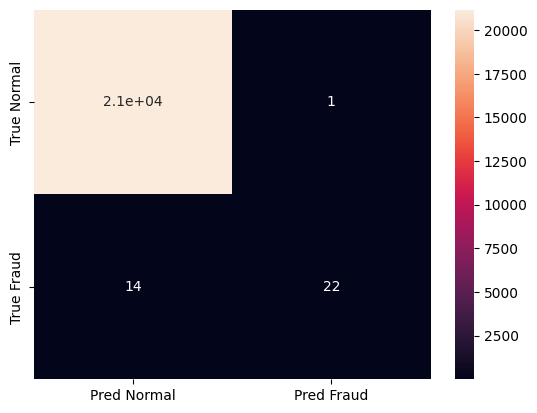

In [29]:
# Create a DataFrame for the confusion matrix results
df_cm = pd.DataFrame(
    results,
    ['True Normal', 'True Fraud'],
    ['Pred Normal', 'Pred Fraud'],
)

# Create a heatmap using seaborn with annotations
cm = sns.heatmap(df_cm, annot=True)

# Get the figure and display it
fig = cm.get_figure()
fig.show()

---

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/3.0/user_guides/mlops/registry/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [30]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Create a Schema for the input features using the values of X_train
input_schema = Schema(X_train.values)

# Create a Schema for the output using y_train
output_schema = Schema(y_train)

# Create a ModelSchema using the defined input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Convert the model schema to a dictionary for inspection
model_schema.to_dict()

{'input_schema': {'tensor_schema': {'shape': '(84816, 9)', 'type': 'object'}},
 'output_schema': {'columnar_schema': [{'name': 'fraud_label',
    'type': 'int64'}]}}

## <span style="color:#ff5f27;">📝 Register model</span>

One of the features in Hopsworks is the model registry. This is where we can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [31]:
# Specify the directory name for saving the model and related artifacts
model_dir = "quickstart_fraud_model"

# Check if the directory already exists; if not, create it
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the trained XGBoost classifier to a joblib file in the specified directory
joblib.dump(clf, model_dir + '/xgboost_model.pkl')

# Save the confusion matrix heatmap figure to an image file in the specified directory
fig.savefig(model_dir + "/confusion_matrix.png")

In [32]:
# Get the model registry
mr = project.get_model_registry()

# Create a Python model named "fraud" in the model registry
fraud_model = mr.python.create_model(
    name="fraud",
    metrics=metrics,             # Specify the metrics used to evaluate the model
    model_schema=model_schema,   # Use the previously defined model schema
    input_example=[4700702588013561],  # Provide an input example for testing deployments
    description="Quickstart Fraud Predictor",  # Add a description for the model
)

# Save the model to the specified directory
fraud_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/19036 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/174862 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/236 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/362646/models/fraud/1


Model(name: 'fraud', version: 1)

---

## <a class="anchor" id="1.5_bullet" style="color:#ff5f27"> 🚀 Model Deployment</a>


### About Model Serving
Models can be served via KFServing or "default" serving, which means a Docker container exposing a Flask server. For KFServing models, or models written in Tensorflow, you do not need to write a prediction file (see the section below). However, for sklearn models using default serving, you do need to proceed to write a prediction file.

In order to use KFServing, you must have Kubernetes installed and enabled on your cluster.

### <span style="color:#ff5f27;">📎 Predictor script for Python models</span>


Scikit-learn and XGBoost models are deployed as Python models, in which case you need to provide a **Predict** class that implements the **predict** method. The **predict()** method invokes the model on the inputs and returns the prediction as a list.

The **init()** method is run when the predictor is loaded into memory, loading the model from the local directory it is materialized to, *ARTIFACT_FILES_PATH*.

The directive "%%writefile" writes out the cell before to the given Python file. We will use the **predict_example.py** file to create a deployment for our model.

In [ ]:
%%writefile predict_example.py
import os
import numpy as np
import hsfs
import joblib


class Predict(object):

    def __init__(self):
        """ Initializes the serving state, reads a trained model"""
        # Get feature store handle
        fs_conn = hsfs.connection()
        self.fs = fs_conn.get_feature_store()

        # Get feature view
        self.fv = self.fs.get_feature_view("transactions_view", 1)

        # Initialize serving
        self.fv.init_serving(1)

        # Load the trained model
        self.model = joblib.load(os.environ["ARTIFACT_FILES_PATH"] + "/xgboost_model.pkl")
        print("Initialization Complete")

    def predict(self, inputs):
        """ Serves a prediction request usign a trained model"""
        feature_vector = self.fv.get_feature_vector({"cc_num": inputs[0][0]})
        feature_vector = feature_vector[:-1]

        return self.model.predict(np.asarray(feature_vector).reshape(1, -1)).tolist() # Numpy Arrays are not JSON serializable

If you wonder why we use the path Models/fraud_tutorial_model/1/model.pkl, it is useful to know that the Data Sets tab in the Hopsworks UI lets you browse among the different files in the project. Registered models will be found underneath the Models directory. Since you saved you model with the name fraud_tutorial_model, that's the directory you should look in. 1 is just the version of the model you want to deploy.

This script needs to be put into a known location in the Hopsworks file system. Let's call the file predict_example.py and put it in the Models directory.

In [ ]:
# Get the dataset API from the project
dataset_api = project.get_dataset_api()

# Specify the file to upload ("predict_example.py") to the "Models" directory, and allow overwriting
uploaded_file_path = dataset_api.upload("predict_example.py", "Models", overwrite=True)

# Construct the full path to the uploaded predictor script
predictor_script_path = os.path.join("/Projects", project.name, uploaded_file_path)

### <span style="color:#ff5f27;">👩🏻‍🔬 Create the deployment</span>

Here, you fetch the model you want from the model registry and define a configuration for the deployment. For the configuration, you need to specify the serving type (default or KFserving).

In [ ]:
# Deploy the fraud model
deployment = fraud_model.deploy(
    name="fraud",                       # Specify the deployment name
    script_file=predictor_script_path,  # Provide the path to the predictor script
)

In [ ]:
print("Deployment is warming up...")
time.sleep(45)

#### The deployment has now been registered. However, to start it you need to run the following command:

In [ ]:
# Start the deployment and wait for it to be running, with a maximum waiting time of 180 seconds
deployment.start(await_running=180)

In [ ]:
# Get the current state of the deployment and describe its details
deployment_state = deployment.get_state().describe()

---

## <span style="color:#ff5f27;"> 📡 Test your Model with an Inference Request </span>

Finally you can start making predictions with your model!

Send inference requests to the deployed model as follows:

In [ ]:
# Make predictions using the deployed model
predictions = deployment.predict(
    inputs=fraud_model.input_example,
)
predictions

## <span style="color:#ff5f27;"> 👾 Try out your Model Interactively </span>

We will build a user interface with Gradio to allow you to enter a credit card category and amount to see if the credit card transaction will be marked as suspected of fraud or not.

In [ ]:
!pip install gradio --quiet
!pip install typing-extensions==4.3.0

In [ ]:
import gradio as gr
import numpy as np

def greet(credit_card_example):
    cc_data = credit_card_example.iloc[0].astype("float")
    # Add missing feature values to the feature vector. Here we hard-code the values,
    # but if you enable the Online Feature Store, you could retrieve them with the following commented out code
    # entry = { "cc_num" : credit_card_example[0]}
    # passed_features = {"category": credit_card_example[0], "amount" : credit_card_example[1]}
    # feature_vector = feature_view.get_feature_vector(entry, passed_features)
    res = deployment.predict(inputs=cc_data.tolist())
    res = res["predictions"][0]
    if res == 0 :
        return "Not Suspected of Fraud"
    return "Suspected of Fraud"

credit_card_example = gr.Dataframe(
    headers=["Credit card number"],
    value=[[fraud_model.input_example[0]]]
)

demo = gr.Interface(greet,
                    credit_card_example,
                    "text",
                    title="Live Credit Card Fraud Detector",
                    description="Enter credit card transaction details.",
                    allow_flagging="never"
)


demo.launch(share=True, debug=True)

## <span style="color:#ff5f27;"> 🥳 Next Steps</span>

Congratulations you've now completed the quickstart example for Managed Hopsworks.


Check out our other tutorials on ➡ https://github.com/logicalclocks/hopsworks-tutorials

Or documentation at ➡ https://docs.hopsworks.ai